In [1]:
from data_collection.data_collector_client import DataCollectorClient
from telethon.tl.types import MessageReactions
import asyncio
from decouple import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import re
def reactions_splitting(message):
    pattern = r"emoticon=['\"](.*?)['\"].*?count=(\d+)"
    matches = re.findall(pattern, message)
    if matches:
        return matches
    else:
        return None

In [3]:
# Function to count the number of reactions in a message using the splitted reactions
def count_reactions(splitted_reaction):
    if(splitted_reaction == None):
        return 0
    else:
        tmp = []
        for i in range(len(splitted_reaction)):
            tmp.append(int(splitted_reaction[:][i][1]))
        return sum(tmp)

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#Function to preprocess a message removing stopwords of the specified language and special characters
def preprocess_message(message, language):
  
  # Removing mentions
  message = re.sub(r"@\w+", "", message)
  # Removing links
  message = re.sub(r"(\[[^\]]+\]|https?://[^\s]+)", "", message)
  # Removing newlines
  message = re.sub(r"\n", " ", message)
  # Removing special characters
  message = re.sub(r"[^\w\s]", " ", message)

  

  # Removing Stopwords
  stop_words = set(stopwords.words(language))
  message = " ".join([word for word in message.split() if word not in stop_words])

  # Convert to lowercase
  message = message.lower()

  # Removing empty words
  message = " ".join(message.split())

  return message

# example
messaggi = ["Ciao a tutti!", "Come va?", "Oggi è una bella giornata\n."]
preprocessed_messages = [preprocess_message(message,"italian") for message in messaggi]
print(preprocessed_messages)


['ciao', 'come va', 'oggi bella giornata']


[nltk_data] Downloading package stopwords to C:\Users\asus-
[nltk_data]     zen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('./data/trial.csv')

df['reactions'].fillna('', inplace=True)
df['reactions'] = df['reactions'].apply(lambda x: count_reactions(reactions_splitting(x)))

In [6]:
ourgroup = "https://t.me/+synza2388S80NWM0"
poligroup = "https://t.me/PoliGruppo"

ourdf = df.loc[df['group'] == ourgroup]
ourdf.head()

,Unnamed: 0,group,sender,text,reply,date,reactions
0,328,https://t.me/+synza2388S80NWM0,NaN,NaN,NaN,2024-02-29 14:30:21+00:00,0
1,327,https://t.me/+synza2388S80NWM0,382281069.0,Hi guys,NaN,2024-02-29 14:34:51+00:00,0
2,326,https://t.me/+synza2388S80NWM0,480675472.0,Hi,NaN,2024-02-29 14:39:04+00:00,0
3,325,https://t.me/+synza2388S80NWM0,NaN,Hi😊,NaN,2024-02-29 14:39:24+00:00,0
4,324,https://t.me/+synza2388S80NWM0,NaN,hey everyone!,NaN,2024-02-29 14:41:48+00:00,0


In [7]:
from datetime import datetime, timedelta
import re
def from_string_to_datetime(date_string):
    formato_stringa = "%Y-%m-%d %H:%M:%S%z"
    oggetto_datetime = datetime.strptime(date_string, formato_stringa)
    return oggetto_datetime

#Removing NaN values from texts and senders
ourdf = ourdf.dropna(subset=['text'])
ourdf = ourdf.dropna(subset=['sender'])
ourdf = ourdf[ourdf['text'].str.split().str.len() >= 4]
ourdf = ourdf.reset_index(drop=True)
ourdf['date'] = ourdf['date'].apply(lambda x: from_string_to_datetime(x))
ourdf.head()

,Unnamed: 0,group,sender,text,reply,date,reactions
0,323,https://t.me/+synza2388S80NWM0,4.806755e+08,I don’t know why I see just Amir,NaN,2024-02-29 14:43:15+00:00,0
1,319,https://t.me/+synza2388S80NWM0,9.844475e+08,The same is happening to me😂,NaN,2024-02-29 14:44:48+00:00,0
2,318,https://t.me/+synza2388S80NWM0,3.822811e+08,"It is ok now, the setting was messed up",NaN,2024-02-29 14:45:14+00:00,0
3,316,https://t.me/+synza2388S80NWM0,5.328389e+09,So once again... \nhey everyone 😄👋,NaN,2024-02-29 14:46:02+00:00,0
4,315,https://t.me/+synza2388S80NWM0,3.822811e+08,"Hi, are you all studying CSE?",NaN,2024-02-29 14:46:31+00:00,0


In [8]:
import math
# Function to merge consecutive messages from the same sender in a dataframe if they are sent within a certain time frame
def merge_consecutive_messages(df,timeframe):
    ourdf = df.copy()
    k = ourdf.shape[0]-1
    i=0
    while i < k-1:

        j=i+1
        delta_timestamp = (ourdf.iloc[j]['date']-ourdf.iloc[i]['date']).seconds
        if(not math.isnan(ourdf.iloc[i]['sender'] )):
            while(ourdf.iloc[i]['sender'] == ourdf.iloc[j]['sender'] and delta_timestamp<timeframe and (ourdf.iloc[j]['reply'] == ourdf.iloc[i]['reply'] or math.isnan(ourdf.iloc[j]['reply']))):
                text = str(ourdf.iloc[i]['text']) + " " + str(ourdf.iloc[j]['text'])
                ourdf.at[i, 'text'] = text
                ourdf.at[i,'reactions'] = ourdf.iloc[j]['reactions'] + ourdf.iloc[i]['reactions']
                
                ourdf.drop(j, inplace=True)
                ourdf.reset_index(drop=True, inplace=True)
                k = k-1
        i=i+1
    return ourdf

In [9]:
ourdf_1 = merge_consecutive_messages(ourdf,300)

In [14]:
ourdf[5:15]

,Unnamed: 0,group,sender,text,reply,date,reactions
5,314,https://t.me/+synza2388S80NWM0,9.844475e+08,"Yes, I am in the AI track",NaN,2024-02-29 14:47:55+00:00,0
6,312,https://t.me/+synza2388S80NWM0,3.822811e+08,This would be my second semester.,NaN,2024-02-29 14:48:44+00:00,0
7,311,https://t.me/+synza2388S80NWM0,4.806755e+08,Me too but not AI,NaN,2024-02-29 14:48:44+00:00,0
8,310,https://t.me/+synza2388S80NWM0,3.822811e+08,"So, Carlo and Barbara would be our tutors, right?",NaN,2024-02-29 14:49:48+00:00,0
9,309,https://t.me/+synza2388S80NWM0,3.822811e+08,Do any of you know them? I mean do you know ho...,NaN,2024-02-29 14:50:24+00:00,0
10,308,https://t.me/+synza2388S80NWM0,9.844475e+08,"I don't know any of them, but I heard that in ...",NaN,2024-02-29 14:53:08+00:00,0
11,307,https://t.me/+synza2388S80NWM0,5.328389e+09,I guess we'll find out about it once we have o...,NaN,2024-02-29 14:54:24+00:00,0
12,306,https://t.me/+synza2388S80NWM0,9.844475e+08,But I think that also depends on the amount of...,NaN,2024-02-29 14:54:43+00:00,0
13,305,https://t.me/+synza2388S80NWM0,3.822811e+08,"Ow, we should setup a meeting then:)",22.0,2024-02-29 14:54:50+00:00,0
14,304,https://t.me/+synza2388S80NWM0,3.822811e+08,I will send the email now,24.0,2024-02-29 14:57:06+00:00,0


In [13]:
ourdf_1[5:15]

,Unnamed: 0,group,sender,text,reply,date,reactions
5,314,https://t.me/+synza2388S80NWM0,9.844475e+08,"Yes, I am in the AI track",NaN,2024-02-29 14:47:55+00:00,0
6,312,https://t.me/+synza2388S80NWM0,3.822811e+08,This would be my second semester.,NaN,2024-02-29 14:48:44+00:00,0
7,311,https://t.me/+synza2388S80NWM0,4.806755e+08,Me too but not AI,NaN,2024-02-29 14:48:44+00:00,0
8,310,https://t.me/+synza2388S80NWM0,3.822811e+08,"So, Carlo and Barbara would be our tutors, rig...",NaN,2024-02-29 14:49:48+00:00,0
9,308,https://t.me/+synza2388S80NWM0,9.844475e+08,"I don't know any of them, but I heard that in ...",NaN,2024-02-29 14:53:08+00:00,0
10,307,https://t.me/+synza2388S80NWM0,5.328389e+09,I guess we'll find out about it once we have o...,NaN,2024-02-29 14:54:24+00:00,0
11,306,https://t.me/+synza2388S80NWM0,9.844475e+08,But I think that also depends on the amount of...,NaN,2024-02-29 14:54:43+00:00,0
12,305,https://t.me/+synza2388S80NWM0,3.822811e+08,"Ow, we should setup a meeting then:)",22.0,2024-02-29 14:54:50+00:00,0
13,304,https://t.me/+synza2388S80NWM0,3.822811e+08,I will send the email now,24.0,2024-02-29 14:57:06+00:00,0
14,303,https://t.me/+synza2388S80NWM0,5.328389e+09,"""Dear MDP team,\n\nThank you for your message....",NaN,2024-03-01 08:33:36+00:00,0


In [144]:
texts = ourdf_1['text']
texts = [str(text) for text in texts]
preprocessed_texts = [preprocess_message(text, "english") for text in texts]
preprocessed_texts = [text for text in preprocessed_texts if text != ""]
print("-----NORMAL TEXTS-----")
print(texts[0:5])
print("\n-----PREPROCESSED TEXTS-----")
print(preprocessed_texts[0:5])

print(len(preprocessed_texts))
print(len(texts))


-----NORMAL TEXTS-----
['I don’t know why I see just Amir', 'The same is happening to me😂', 'It is ok now, the setting was messed up', 'So once again... \nhey everyone 😄👋', 'Hi, are you all studying CSE?']

-----PREPROCESSED TEXTS-----
['i know i see amir', 'the happening', 'it ok setting messed', 'so hey everyone', 'hi studying cse']
197
197


In [145]:
langs = ["en" for i in range(len(texts))]

from laserembeddings import Laser
laser = Laser()

# if all sentences are in the same language:
embeddings = laser.embed_sentences(
    texts,
    lang=langs)

embeddings.shape

(197, 1024)

In [146]:
poli_texts = polidf['text']
poli_texts_strings = [str(text) for text in poli_texts if isinstance(text, str)] 

In [147]:
polidf = df.loc[df['group'] == poligroup]
polidf.head()
poli_preprocessed_texts = [preprocess_message(text, "italian") for text in poli_texts_strings]

In [148]:
print(preprocessed_texts[0:5])
prep_text = preprocessed_texts

['i know i see amir', 'the happening', 'it ok setting messed', 'so hey everyone', 'hi studying cse']


In [149]:
laser = Laser()
langs = ['en' for i in range(len(prep_text))]
embeddings2 = laser.embed_sentences(
  prep_text,
  lang=langs)

In [150]:
#Return the average cosine similarity between the last k embeddings
def average_k_cosine_similarity(embeddings, k):
    tmp_similarity = []
    for i in np.arange(k):
        if i != k-1:
            tmp_similarity.append(np.dot(embeddings[k-1], embeddings[i]) / (np.linalg.norm(embeddings[k-1]) * np.linalg.norm(embeddings[i])))
    return np.mean(tmp_similarity)

print(len(embeddings))

similarities = average_k_cosine_similarity(embeddings, 5)

197


In [151]:
def cosine_similarities_last_k_sliding_window (embeddings2, k):
    trial_similarities = list()
    for i in np.arange(len(embeddings2)-k):
#        if i+2 > k:
        window = [emb for emb in embeddings2[i:i+k]]
        trial_similarities.append(average_k_cosine_similarity(window, k))
            #329 print(i)
#        else:
#            window = [emb for emb in embeddings2[0:i+2]]
#            lenw = len(window)
#            lent = len(trial_similarities)
#            trial_similarities.append(average_k_cosine_similarity(window, i+2))
    return trial_similarities

0.51719564
189
197


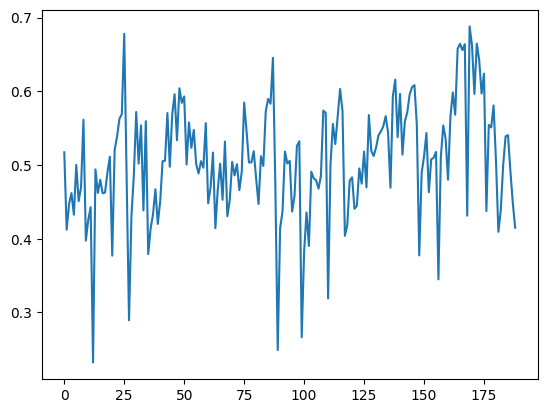

In [154]:
k = 8
our_group_similarities = cosine_similarities_last_k_sliding_window(embeddings2, k)

print(our_group_similarities[0])

print(len(our_group_similarities))
print(len(embeddings2))

# Plot the list
plt.plot(our_group_similarities)
plt.show()


In [158]:
def watch_messages_in_a_range(messages, start, end, k):
    for i in np.arange(start, end):
        print(str(i) +" : " + messages[i+k])
        
print(texts[0:5])
#printing indices where the average cosine similarity of the previous k message is below 0.30
indices = [i for i, num in enumerate(our_group_similarities) if num < 0.43]
#minindex = min(enumerate(our_group_similarities.min()))
minimum = [i for i, num in enumerate(our_group_similarities) if num == min(our_group_similarities)]
print(minimum)
print(indices)
watch_messages_in_a_range(preprocessed_texts,80,110, k)

['I don’t know why I see just Amir', 'The same is happening to me😂', 'It is ok now, the setting was messed up', 'So once again... \nhey everyone 😄👋', 'Hi, are you all studying CSE?']
[12]
[1, 9, 10, 12, 20, 27, 35, 36, 39, 63, 89, 90, 99, 100, 102, 110, 117, 118, 148, 156, 181, 188]
80 : they replyed message they basically said could privacy problems need talk projecy assembly willing meet us hey ciao hai scritto alla persona giusta innanzitutto mi scuso per il ritardo nella risposta ero via e non stavo guardando telegram il progetto sembra estremamente interessante va detto che è una richiesta piuttosto inusuale ahah ne parlerò con gli altri ragazzi nel consiglio direttivo di polinetwork quanto abbiamo stringenti politiche di privacy e ti faremo sapere cosa viene detto caso vederci di persona per parlarne più nel dettaglio non sarebbe affatto una brutta idea ogni caso buona fortuna con il progetto e buona serata
81 : guys i probably 10 minutes late wait start meeting
82 : ok i office 